In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy

# The model

+ Modified Richardson iteration with U-Net preconditioner
+ U-Net coincides with filtering preconditioner
+ No serialization is performed
+ U-Net architecture:

U-Net = skip connection starts here $\rightarrow$ convolution with stride $1$ $\rightarrow$ convolution with stride $>1$ $\rightarrow$ U-Net $\rightarrow$ transposed convolution with stride $>1$ $\rightarrow$ transposed convolution with stride $1$ $\rightarrow$ skip connection ends here

In [2]:
# U-Net
def u_net(x, projection_filter_pre, projection_filter_post, pre_smoothing_filters, post_smoothing_filters, strides, N_layers, k=0):
  input_shape = tf.shape(x)
  if k == N_layers:
    y = x
    x = tf.nn.convolution(x, pre_smoothing_filters[k], strides=[1, 1], padding="SAME")
    x = tf.nn.conv_transpose(x, post_smoothing_filters[k], x.shape, strides=[1, 1], padding="SAME")
    return x + y
  y = x
  x = tf.nn.convolution(x, pre_smoothing_filters[k], strides=[1, 1], padding="SAME")
  x = tf.nn.convolution(x, projection_filter_pre[k], strides=strides)
  x = u_net(x, projection_filter_pre, projection_filter_post, pre_smoothing_filters, post_smoothing_filters, strides, N_layers, k=k+1)
  x = tf.nn.conv_transpose(x, projection_filter_post[k], input_shape, strides=strides, padding="VALID")
  x = tf.nn.conv_transpose(x, post_smoothing_filters[k], x.shape, strides=[1, 1], padding="SAME")
  return x + y

# modified Richardson solver
def u_net_solver(x, b, A, projection_filter_pre, projection_filter_post, pre_smoothing_filters, post_smoothing_filters, strides, N_levels):
  # diagonal is always 1
  r = b - A(x)
  x = x + u_net(r, projection_filter_pre, projection_filter_post, pre_smoothing_filters, post_smoothing_filters, strides, N_levels)
  return x

# approximate spectral radius
def stochastic_trace_u_net_solver(A, J, N_levels, projection_filter_pre, projection_filter_post, pre_smoothing_filters, post_smoothing_filters, strides, N_sweeps=10, batch_size=10):
  x = tf.Variable(np.random.choice([-1, 1], (batch_size, 2**J-1, 2**J-1, 1)), dtype=projection_filter_pre[0].dtype)
  for _ in range(N_sweeps):
    x = u_net_solver(x, x*0, A, projection_filter_pre, projection_filter_post, pre_smoothing_filters, post_smoothing_filters, strides, N_levels)
  return ((tf.norm(x)**2)/batch_size)**(1/(2*N_sweeps))

# Equations

In [3]:
# equations

poisson_filter = tf.Variable(np.array([[0, -1/4, 0], [-1/4, 1, -1/4], [0, -1/4, 0]]).reshape(3, 3, 1, 1), dtype=tf.float32, trainable=False, name="Poisson")
A_poisson = lambda x: tf.nn.convolution(x, poisson_filter, strides=[1, 1], padding="SAME")

poisson_large_filter = tf.Variable(np.array([[0, 0, 1/60, 0, 0], [0, 0, -16/60, 0, 0], [1/60, -16/60, 1, -16/60, 1/60], [0, 0, -16/60, 0, 0], [0, 0, 1/60, 0, 0]]).reshape(5, 5, 1, 1), dtype=tf.float32, trainable=False, name="Poisson large")
A_poisson_large = lambda x: tf.nn.convolution(x, poisson_large_filter, strides=[1, 1], padding="SAME")

mehrstellen_filter = tf.Variable(np.array([[-1/20, -1/5, -1/20], [-1/5, 1, -1/5], [-1/20, -1/5, -1/20]]).reshape(3, 3, 1, 1), dtype=tf.float32, trainable=False, name="Mehrstellen")
A_mehrstellen = lambda x: tf.nn.convolution(x, mehrstellen_filter, strides=[1, 1], padding="SAME")

epsilon = 10
poisson_anisotropic_filter = tf.Variable(np.array([[0, -1/(2+2*epsilon), 0], [-epsilon/(2+2*epsilon), 1, -epsilon/(2+2*epsilon)], [0, -1/(2+2*epsilon), 0]]).reshape(3, 3, 1, 1), dtype=tf.float32, trainable=False, name="Anisotropic Poisson")
A_anisotropic = lambda x: tf.nn.convolution(x, poisson_anisotropic_filter, strides=[1, 1], padding="SAME")

tau = 3/4
mixed_filter = tf.Variable(np.array([[-tau/8, -1/4, tau/8], [-1/4, 1, -1/4], [tau/8, -1/4, -tau/8]]).reshape(3, 3, 1, 1), dtype=tf.float32, trainable=False, name="Mixed")
A_mixed = lambda x: tf.nn.convolution(x, mixed_filter, strides=[1, 1], padding="SAME")

# Training

In [4]:
A = A_poisson # change this line to try different linear equation
N_batch = 10

J = 5
N_levels = J - 1

u_net_strides = [2, 2]

# training all present convolutions. note, that N_levels = J - 1 but additional pre- and postsmoothing filters are present!
pre_smoothing_filters = [tf.Variable(np.outer([1/2, 1, 1/2], [[1/2], [1], [1/2]]).reshape((3, 3, 1, 1))/2, dtype=tf.float32, trainable=True, name="pre_smoothing_filter_"+str(i)) for i in range(N_levels+1)]
post_smoothing_filters = [tf.Variable(np.outer([1/2, 1, 1/2], [[1/2], [1], [1/2]]).reshape((3, 3, 1, 1))/2, dtype=tf.float32, trainable=True, name="post_smoothing_filter_"+str(i)) for i in range(N_levels+1)]
projection_filter_pre = [tf.Variable(np.outer([1/2, 1, 1/2], [[1/2], [1], [1/2]]).reshape((3, 3, 1, 1))/2, dtype=tf.float32, trainable=True, name="pre_projection_filter_"+str(i)) for i in range(N_levels)]
projection_filter_post = [tf.Variable(np.outer([1/2, 1, 1/2], [[1/2], [1], [1/2]]).reshape((3, 3, 1, 1))/2, dtype=tf.float32, trainable=True, name="post_projection_filter_"+str(i)) for i in range(N_levels)]

variables = pre_smoothing_filters + post_smoothing_filters + projection_filter_pre + projection_filter_post

In [5]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
N_epoch = 2000

history = np.zeros(N_epoch)
for i in range(N_epoch):
  with tf.GradientTape() as tape:
    loss = stochastic_trace_u_net_solver(A, J, N_levels, projection_filter_pre, projection_filter_post, pre_smoothing_filters, post_smoothing_filters, u_net_strides, N_sweeps=10, batch_size=10)
  opt.apply_gradients(zip(tape.gradient(loss, variables), variables))
  history[i] = loss.numpy()

final loss =  0.64342713


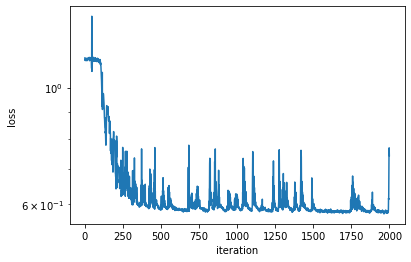

In [6]:
# training history
final_loss = stochastic_trace_u_net_solver(A, J, N_levels, projection_filter_pre, projection_filter_post, pre_smoothing_filters, post_smoothing_filters, u_net_strides, N_sweeps=10, batch_size=10).numpy()
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(history)
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
print("final loss = ", final_loss);

# Model evaluation

In [7]:
for J in [3, 4, 5, 6, 7, 8, 9, 10, 11]:
  N_levels_ = min(N_levels, J-1)

  spectral_radius = stochastic_trace_u_net_solver(A, J, N_levels_, projection_filter_pre, projection_filter_post, pre_smoothing_filters, post_smoothing_filters, u_net_strides, N_sweeps=10, batch_size=10).numpy()
  print("J = ", J, " spectral radius = ", spectral_radius)

J =  3  spectral radius =  0.49641305
J =  4  spectral radius =  0.54704124
J =  5  spectral radius =  0.6452189
J =  6  spectral radius =  0.85153264
J =  7  spectral radius =  0.9834595
J =  8  spectral radius =  1.1335756
J =  9  spectral radius =  1.2149988
J =  10  spectral radius =  1.3108406
J =  11  spectral radius =  1.4078285
